In [1]:
import os
import numpy as np
import torch

In [2]:
from torch.utils.data import DataLoader
from generate_data import generate_mec_data
from utils import load_model
from problems import MEC

In [3]:
# 定义 plot
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def plot_mec(data, tour, ax):
    
    depot = data['UAV_start_pos'].cpu().numpy().tolist()
    locs = data['task_position'].cpu().numpy().tolist()
    tour = tour.cpu().numpy().tolist()
    
    loc = depot + locs
    tour = [0] + tour 
    # 提取按照 tour 顺序排列的坐标
    x_vals = [loc[i][0] for i in tour]
    y_vals = [loc[i][1] for i in tour]
    
    # 绘制路径线
    ax.plot(x_vals, y_vals, marker='o', linestyle='-', color='b', label='Path')

    # 可选: 在每对相邻的点之间绘制箭头
    for i in range(len(tour) - 1):
        x_start, y_start = loc[tour[i]]
        x_end, y_end = loc[tour[i+1]]
        
        # 在两个点之间画箭头，箭头的大小和样式可以调整
        ax.annotate('', xy=(x_end, y_end), xytext=(x_start, y_start),
                    arrowprops=dict(facecolor='black', edgecolor='black', arrowstyle='->', lw=2, mutation_scale=20))

    # 可选: 标注每个点
    for i, (x, y) in enumerate(zip(x_vals, y_vals)):
        ax.text(x, y, f'{tour[i]}', fontsize=30, ha='right', color='red')
    
    # 可选: 绘制第一个和最后一个点的线段，表示起点和终点
    ax.plot([x_vals[0], x_vals[-1]], [y_vals[0], y_vals[-1]], '-', label='Start-End')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('MEC Path with Arrows')
    ax.legend()


In [4]:
# 获得符合约束的拓扑学排序
from collections import defaultdict
def all_topological_sorts(n, dep):
   
    graph = defaultdict(list)
    in_degree = [0] * (n + 1) 
    for i in range(len(dep)-1):
        u, v = dep[i], dep[i + 1]
        graph[u].append(v)
        in_degree[v] += 1
   
    result = []
    current_sort = []
    
    zero_in_degree_nodes = {i for i in range(1, n + 1) if in_degree[i] == 0}
    
    def backtrack():
        if len(current_sort) == n:
            result.append(current_sort[:])
            return
        for node in list(zero_in_degree_nodes):
            current_sort.append(node)
            zero_in_degree_nodes.remove(node)
            for neighbor in graph[node]:
                in_degree[neighbor] -= 1
                if in_degree[neighbor] == 0:
                    zero_in_degree_nodes.add(neighbor)
            backtrack()
            current_sort.pop()
            for neighbor in graph[node]:
                in_degree[neighbor] += 1
                if in_degree[neighbor] == 1:
                    zero_in_degree_nodes.remove(neighbor)
                elif in_degree[neighbor] == 0:
                    zero_in_degree_nodes.add(neighbor)
            zero_in_degree_nodes.add(node)
    backtrack()
    
    return result


In [5]:
# 求 loss
from demopts import *
from demopts import getloss

In [6]:
# 求最优解 (穷举)
def chechformodel(data):
    dependency = (data["dependencys"]+1).cpu().numpy().tolist()
    n = data["task_data"].size(0)
    paths = all_topological_sorts(n, dependency)
    best_loss = math.inf
    best_p = paths[0]
    best_ps = [best_p]
    for p in paths:
       loss = getloss(data,p)
       if loss < best_loss:
        best_loss = loss
        best_p = p
        best_ps = [p]
       elif loss == best_loss:
        best_ps += [p]

    print("the fact best loss : ", best_loss)
    print("the fact best tours : ")    
    for p in best_ps:
       print(p)    
    

In [7]:
# 加载 model
model, _ = load_model('outputs/mec_4/demo_4_20241205T222731/')


d:\ML\attention-learn-to-route-master\AttentionMyTSP_czy\attention-learn-to-route-master\utils\functions.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.lo

  [*] Loading model from outputs/mec_4/demo_4_20241205T222731/epoch-99.pt


d:\ML\attention-learn-to-route-master\AttentionMyTSP_czy\attention-learn-to-route-master\utils\functions.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_data = tor

In [8]:
# 生成 batch
torch.manual_seed(1234)
dataset = MEC.make_dataset(size=4, num_samples=1, dependency=model.dependency)
# Need a dataloader to batch instances
dataloader = DataLoader(dataset, batch_size=1)
# Make var works for dicts
batch = next(iter(dataloader))


In [9]:
# Run the model
model.eval()
model.set_decode_type('greedy')

with torch.no_grad():
    cost, log_p, pi = model(batch, return_pi=True)
tours = pi

print("model solution"," with dp of ", [i+1 for i in model.dependency])
for i in range(pi.size(0)):
   print( cost[i].item(), " -|- ", pi[i])
    


model solution  with dp of  [4, 2]
104634.640625  -|-  tensor([1, 3, 4, 2])


the model cost :  104634.65547349455
the model tour :  [1, 3, 4, 2]
the fact best loss :  55469.41262838193
the fact best tours : 
[3, 1, 4, 2]


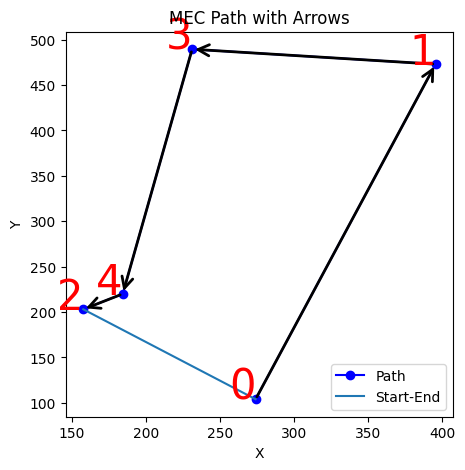

In [10]:
# Plot the results
for i, (data, tour) in enumerate(zip(dataset, tours)):
   fig, ax = plt.subplots(figsize=(5, 5))
   plot_mec(data, tour, ax)
   tour=tour.cpu().numpy().tolist()
   print("the model cost : ", getloss(data,tour))
   print("the model tour : ", tour)
   chechformodel(data)
 
plt.show()
